In [36]:
import pandas as pd

from matplotlib import pyplot as plt

df = pd.read_csv(r'C:\Users\bueck\PycharmProjects\ibsys2SCM\user-docs\data_analyses\material_costs.csv', delimiter=',',
                 decimal=",", thousands=".", encoding='utf-8')
df.head(40)


,Artikelnummer,Bezeichnung,Verwendung,Startmenge,Startpreis[€],Lieferkosten[€],Lieferzeit[Perioden],Lieferzeitabweichung,Bearbeitungsarbeitsplatz 1,Unnamed: 9,...,Bearbeitungsarbeitsplatz11,Unnamed: 27,Bearbeitungsarbeitsplatz12,Unnamed: 29,Bearbeitungsarbeitsplatz13,Unnamed: 31,Bearbeitungsarbeitsplatz14,Unnamed: 33,Bearbeitungsarbeitsplatz15,Unnamed: 35
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bearbeitungszeit,Rüstzeit,...,Bearbeitungszeit,Rüstzeit,Bearbeitungszeit,Rüstzeit,Bearbeitungszeit,Rüstzeit,Bearbeitungszeit,Rüstzeit,Bearbeitungszeit,Rüstzeit
1,1P,Kinderfahrrad,NaN,100.0,156.13,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2P,Damenfahrrad,NaN,100.0,163.33,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3P,Herrenfahrrad,NaN,100.0,165.08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4E,Hinterradgruppe,K,100.0,40.85,NaN,NaN,NaN,NaN,NaN,...,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5E,Hinterradgruppe,D,100.0,39.85,NaN,NaN,NaN,NaN,NaN,...,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6E,Hinterradgruppe,H,100.0,40.85,NaN,NaN,NaN,NaN,NaN,...,3,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7E,Vorderradgruppe,K,100.0,35.85,NaN,NaN,NaN,NaN,NaN,...,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8E,Vorderradgruppe,D,100.0,35.85,NaN,NaN,NaN,NaN,NaN,...,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9E,Vorderradgruppe,H,100.0,35.85,NaN,NaN,NaN,NaN,NaN,...,3,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df = df.iloc[1:]
# Artikelnummer: extract numeric part and symbol
df['article_id'] = df['Artikelnummer'].astype(str).str.extract(r'([\d\.]+)')[0]
df['article_id'] = df['article_id'].str.replace('.', '', regex=False)
df['item_type'] = df['Artikelnummer'].astype(str).str.extract(r'([PEK])')[0]

# Remove Bezeichnung column
df.drop(columns=['Bezeichnung'], inplace=True, errors='ignore')

# Verwendung: split into used_for_child, used_for_men, used_for_women
df['used_for_child'] = df['Verwendung'].apply(lambda x: 1 if 'K' in str(x) else 0)
df['used_for_men'] = df['Verwendung'].apply(lambda x: 1 if 'H' in str(x) else 0)
df['used_for_women'] = df['Verwendung'].apply(lambda x: 1 if 'D' in str(x) else 0)

# Rename and reformat columns
# Startmenge -> start_quantity, remove dots (thousands separator)
df['start_quantity'] = df['Startmenge']

# Startpreis [ € ] -> price_per_part, remove thousand markers and convert comma to dot
df['price_per_part'] = df['Startpreis[€]']

# Lieferkosten [ € ] -> order_price
df['order_price'] = df['Lieferkosten[€]']

# Lieferzeit [Perioden] -> order_duration
df['order_duration'] = df['Lieferzeit[Perioden]']

# rename Lieferzeitabweichung to order_86_deviation and convert to english number format
df['order_86_deviation'] = df['Lieferzeitabweichung']

# calculate order_standard_deviation and drop the original order_86_deviation column
df['order_standard_deviation'] = df['order_86_deviation'] / 1.5
df.drop(columns=['order_86_deviation'], inplace=True)
# Lieferzeitabweichung -> order_86_deviation

# Add discount_quantity and discount_amount for item_type K
df['discount_quantity'] = df.apply(lambda row: row['start_quantity'] if row['item_type'] == 'K' else 0, axis=1)
df['discount_amount'] = df.apply(lambda row: 0.1 if row['item_type'] == 'K' else 0, axis=1)
cols = ['article_id', 'item_type', 'used_for_child', 'used_for_men', 'used_for_women',
        'start_quantity', 'price_per_part', 'order_price', 'order_duration', 'order_standard_deviation',
        'discount_quantity', 'discount_amount']
df = df[cols]
df.to_csv('material_costs_cleaned.csv', index=False, encoding='utf-8')


In [38]:
df.describe()

,used_for_child,used_for_men,used_for_women,start_quantity,price_per_part,order_price,order_duration,order_standard_deviation,discount_quantity,discount_amount
count,59.000000,59.000000,59.000000,59.000000,59.000000,29.000000,29.000000,29.000000,59.000000,59.000000
mean,0.576271,0.576271,0.576271,1905.084746,33.428475,58.620690,1.521034,0.202299,1844.067797,0.049153
std,0.498390,0.498390,0.498390,4844.670863,50.005695,15.346972,0.512879,0.078645,4867.672076,0.050422
min,0.000000,0.000000,0.000000,100.000000,0.060000,50.000000,0.700000,0.066667,0.000000,0.000000
25%,0.000000,0.000000,0.000000,100.000000,1.180000,50.000000,1.200000,0.133333,0.000000,0.000000
50%,1.000000,1.000000,1.000000,300.000000,12.400000,50.000000,1.600000,0.200000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,900.000000,37.850000,75.000000,1.700000,0.266667,900.000000,0.100000
max,1.000000,1.000000,1.000000,22000.000000,165.080000,100.000000,3.200000,0.333333,22000.000000,0.100000


In [39]:
df.head()

,article_id,item_type,used_for_child,used_for_men,used_for_women,start_quantity,price_per_part,order_price,order_duration,order_standard_deviation,discount_quantity,discount_amount
1,1,P,0,0,0,100.0,156.13,NaN,NaN,NaN,0.0,0.0
2,2,P,0,0,0,100.0,163.33,NaN,NaN,NaN,0.0,0.0
3,3,P,0,0,0,100.0,165.08,NaN,NaN,NaN,0.0,0.0
4,4,E,1,0,0,100.0,40.85,NaN,NaN,NaN,0.0,0.0
5,5,E,0,0,1,100.0,39.85,NaN,NaN,NaN,0.0,0.0


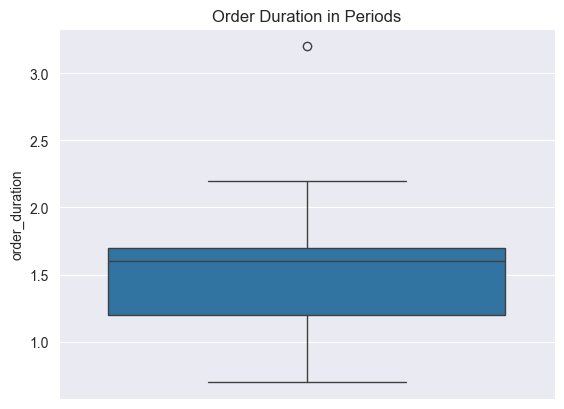

In [40]:
import seaborn as sns

df = pd.read_csv('material_costs_cleaned_edited.csv', encoding='utf-8')
sns.boxplot(y=df['order_duration'])
plt.title('Order Duration in Periods')
plt.show()

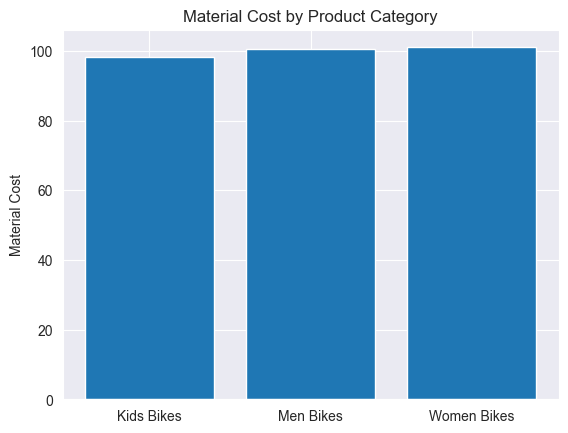

In [41]:
import matplotlib.pyplot as plt

df_k = df[df['item_type'] == 'K']
kids_cost = (df_k['price_per_part'] * df_k['quantity_used_for_child']).sum()
men_cost = (df_k['price_per_part'] * df_k['quantity_used_for_men']).sum()
women_cost = (df_k['price_per_part'] * df_k['quantity_used_for_women']).sum()

categories = ['Kids Bikes', 'Men Bikes', 'Women Bikes']
costs = [kids_cost, men_cost, women_cost]

plt.figure()
plt.bar(categories, costs)
plt.ylabel('Material Cost')
plt.title('Material Cost by Product Category')
plt.show()


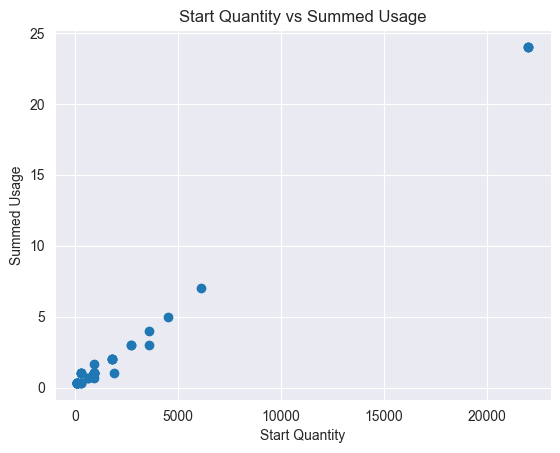

In [42]:
start_quantities = df['start_quantity']
summed_usage = (df['quantity_used_for_child'] + df['quantity_used_for_men'] + df['quantity_used_for_women']) / 3

plt.scatter(start_quantities, summed_usage)
plt.xlabel('Start Quantity')
plt.ylabel('Summed Usage')
plt.title('Start Quantity vs Summed Usage')
plt.show()


(0.0, 2000.0)

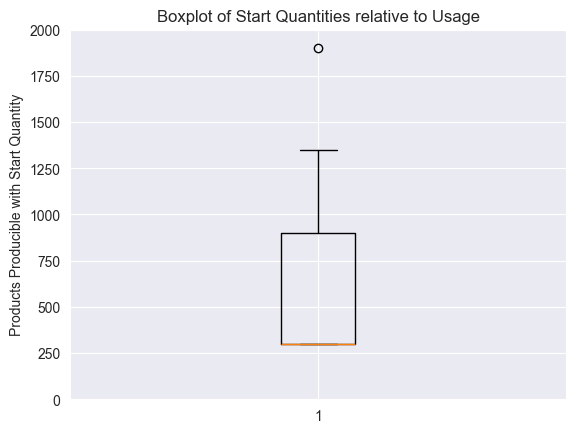

In [43]:
usage_relative_quantities = start_quantities / summed_usage
plt.boxplot(usage_relative_quantities)
plt.ylabel('Products Producible with Start Quantity')
plt.title('Boxplot of Start Quantities relative to Usage')
plt.ylim(0, 2000)

In [44]:
df.head()

,article_id,item_type,quantity_used_for_child,quantity_used_for_women,quantity_used_for_men,start_quantity,price_per_part,order_price,order_duration,order_standard_deviation,discount_quantity,discount
0,1,P,1,0,0,100.0,156.13,NaN,NaN,NaN,0.0,0.0
1,2,P,0,1,0,100.0,163.33,NaN,NaN,NaN,0.0,0.0
2,3,P,0,0,1,100.0,165.08,NaN,NaN,NaN,0.0,0.0
3,4,E,1,0,0,100.0,40.85,NaN,NaN,NaN,0.0,0.0
4,5,E,0,1,0,100.0,39.85,NaN,NaN,NaN,0.0,0.0


In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Filter only K counter
df_k = df[df['item_type'] == 'K'].copy()



(0.0, 1.0)

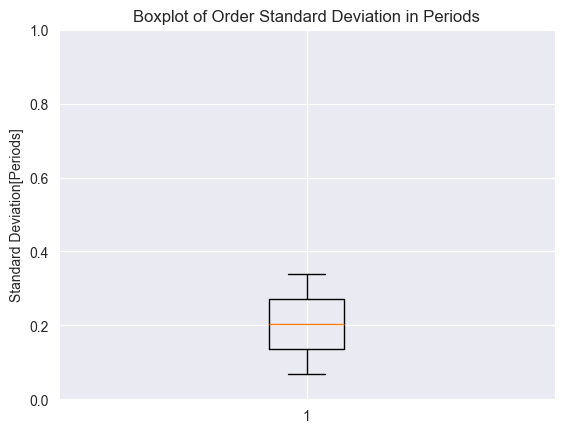

In [53]:
plt.boxplot(df_k['order_standard_deviation'])
plt.ylabel('Standard Deviation[Periods]')
plt.title('Boxplot of Order Standard Deviation in Periods')
plt.ylim(0, 1)

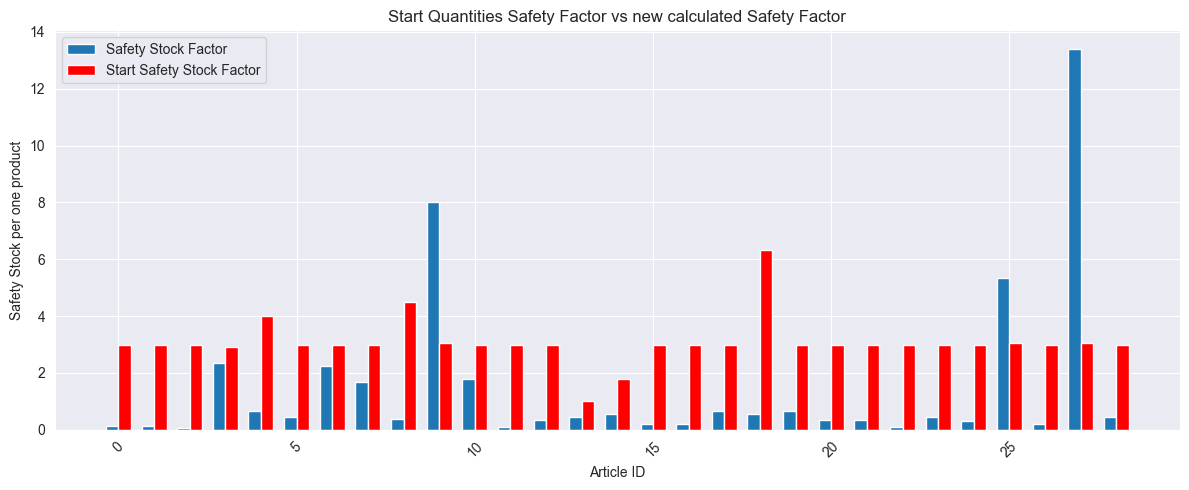

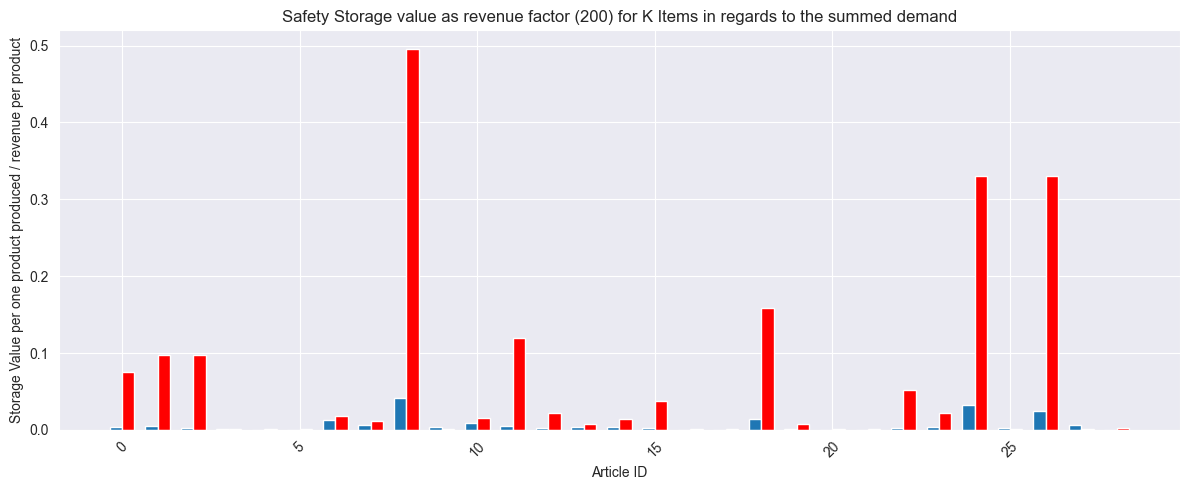

In [47]:

AVERAGE_PRODUCT_DEMAND = 300
AVERAGE_PRODUCT_PRICE = 200
# Calculate actual demand from the two columns that give the actual usage
df_k['average_demand'] = (df['quantity_used_for_child'] + df['quantity_used_for_men'] + df[
    'quantity_used_for_women']) / 3

# Safety stock is based on variability in order and the actual demand.
# We use a safety factor (z = 1.65) to determine the safety stock.
z = 1.65
df_k['safety_stock_factor'] = z * df_k['order_standard_deviation'] * df_k['average_demand']
df_k['start_safety_stock_factor'] = df_k['start_quantity'] / df_k['average_demand'] / AVERAGE_PRODUCT_DEMAND
# Storage cost depends on the safety stock level and the product value (price_per_part)
df_k['storage_value_factor'] = df_k['safety_stock_factor'] * df_k['price_per_part']
df_k['start_storage_value_factor'] = df_k['start_safety_stock_factor'] * df_k['price_per_part']
# Visualize Safety Stock for each K item
plt.figure(figsize=(12, 5))
width = 0.35
indices = np.arange(len(df_k))
plt.bar(indices - width / 2, df_k['safety_stock_factor'], width, label='Safety Stock Factor')
plt.bar(indices + width / 2, df_k['start_safety_stock_factor'], width, label='Start Safety Stock Factor', color='red')
plt.xlabel('Article ID')
plt.ylabel('Safety Stock per one product')
plt.title('Start Quantities Safety Factor vs new calculated Safety Factor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

df_k['safety_store_per_revenue'] = df_k['storage_value_factor'] / AVERAGE_PRODUCT_PRICE

plt.figure(figsize=(12, 5))
width = 0.35
indices = np.arange(len(df_k))
plt.bar(indices - width / 2, df_k['safety_store_per_revenue'], width, label='Safety Stock Factor')
plt.bar(indices + width / 2, df_k['start_storage_value_factor'] / AVERAGE_PRODUCT_PRICE, width,
        label='Start Safety Stock Factor', color='red')
plt.xlabel('Article ID')
plt.ylabel('Storage Value per one product produced / revenue per product')
plt.title('Safety Storage value as revenue factor (200) for K Items in regards to the summed demand')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [48]:
safety_stock_per_revenue = df_k['safety_store_per_revenue'].sum()

In [49]:
AVERAGE_REVENUE = AVERAGE_PRODUCT_DEMAND * AVERAGE_PRODUCT_PRICE

stock_value = safety_stock_per_revenue * AVERAGE_REVENUE

stock_value

np.float64(11479.874999999996)

In [50]:
import math


def order_duration_safety_factor(order_duration):
    return max(1.0, math.sqrt(order_duration))

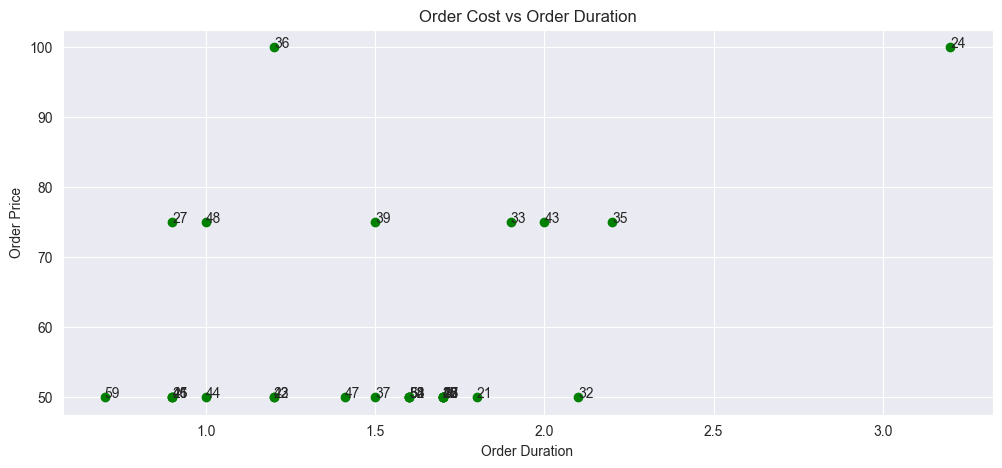

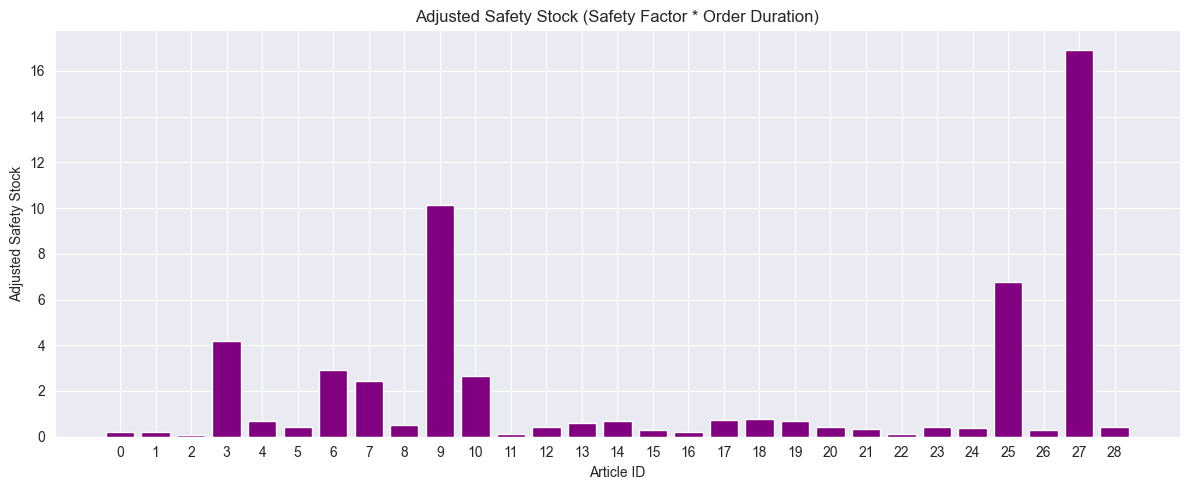

In [51]:
df_k['adjusted_safety_stock_linear'] = df_k['safety_stock_factor'] * df_k['order_duration']
df_k['adjusted_safety_stock_sqrt'] = df_k['safety_stock_factor'] * df_k['order_duration'].apply(
    order_duration_safety_factor)

indices = np.arange(len(df_k))
width = 0.35

plt.figure(figsize=(12, 5))

# 2. Scatter plot: Order Cost vs Order Duration
plt.scatter(df_k['order_duration'], df_k['order_price'], color='green')
for i, txt in enumerate(df_k['article_id']):
    plt.annotate(txt, (df_k['order_duration'].iloc[i], df_k['order_price'].iloc[i]))
plt.xlabel('Order Duration')
plt.ylabel('Order Price')
plt.title('Order Cost vs Order Duration')
plt.show()

plt.figure(figsize=(12, 5))

# 4. Adjusted Safety Stock (including order duration)
plt.bar(indices, df_k['adjusted_safety_stock_sqrt'], color='purple')
plt.xlabel('Article ID')
plt.ylabel('Adjusted Safety Stock')
plt.title('Adjusted Safety Stock (Safety Factor * Order Duration)')
plt.xticks(indices)
plt.tight_layout()
plt.show()


Durchnittlische Belastung pro Arbeitsplatz also wie eng dort die Kapazitäten prinzipiell sind.
kritischer Pfad, längster Pfad. Bei den Eigenerzeugnissen weniger auf Lager halten von Teilen die schneller produziert werden können.


